# Classification: Support Vector Machines, Encoding, and Data Balancing
In this notebook, we will continue our work with classifiers by introducing a new model, three new metrics, a way to encode and decode categorical data, and more ways in which you can handle imbalanced data.

Let's begin with our everyday tasks: Loading the data, cleaning, and generating our train/test split.

For this example, we will use a wine dataset that contains two columns that can be made into categorical data:
- Type, which splits wine into red and white
- Quality, which splits wine into ten different score categories

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In this dataset, there are a few missing values. We will not try to fix them in this notebook, but remember we can use something like data imputation if we do not want to just delete them.

In [2]:
wine = pd.read_csv(r'C:\Users\Raul\OneDrive\Escritorio\CS\TC2004B.101\data\winequalityN.csv')
wine.dropna(inplace=True)
wine

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,white,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,white,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6491,red,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


Before we start doing anything else, we should check to see if our categories are balanced! For this notebook, we will only be using the "type" column.

'white'

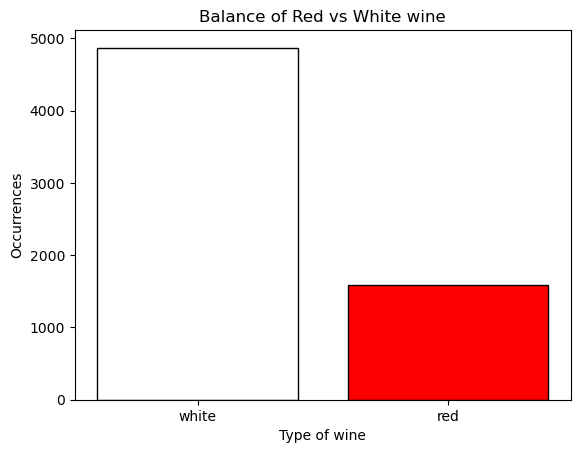

In [3]:
y = wine["type"]
plt.bar(y.value_counts().index, y.value_counts()[:],
        color = ["white","red"],
        edgecolor = ["black",[0,0,0]]
       )
plt.xlabel("Type of wine")
plt.ylabel("Occurrences")
plt.title("Balance of Red vs White wine")
y.value_counts().index[0]

The split is roughly 75-25, so our data is NOT balanced. This imbalance is not too extreme, but it will still affect our results. Our first experiments will be based on using SVMs without any other techniques, to see what happens. Let's split our dataset into inputs and outputs now!

In [4]:
X = wine.iloc[:,1:]
X

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
6491,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6
6492,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6494,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


We'll be using an 80/20 train/test split.

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, shuffle=True)

## SVMs: Support Vector Machines
SVMs make use a hyperplane (meaning, a plane which can be of any number of dimensions) that splits a target space into different sections which maximize the distance between classes:

<center>
  <img src="https://editor.analyticsvidhya.com/uploads/729834.png" />
</center>

What's more, SVMs are not restricted to only linear decision boundaries. They can make use of a kernel to translate the linear boundary to different shapes, and complexities. For this example, we will be using a polynomial kernel with a degree of two, meaning it can describe some curved boundaries. The selection of the kernel is not a trivial task, and should be given some thought in real applications.

In [6]:
from sklearn.svm import SVC 
svclassifier = SVC(
    C = 1.0, # Regularization term. Higher = more noise = less overfitting
    kernel = 'poly', # Kernel. 'rbf' is the default, 'linear' and 'poly' are also available
    degree = 2, # Degree of the polynomial. Higher = more complexity
    class_weight = None, # Weights for rebalancing or for changing class importance
    max_iter = 10000, # Set to none to let it run as much as possible.
    random_state = 42, 
)

In [7]:
svclassifier.fit(X_train,y_train)

SVC(degree=2, kernel='poly', max_iter=10000, random_state=42)

We obtain a significant amount of accuracy using this model: 93%! However, we already know this is only half the story: Let's check the confusion matrix.

In [8]:
svclassifier.score(X_test, y_test)

0.9296210363495746

In [9]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sns

In [10]:
y_pred = svclassifier.predict(X_test)
svclassifier.classes_ # You can use this to get the labels and the order they were learned in

array(['red', 'white'], dtype=object)

Text(58.222222222222214, 0.5, 'Labels')

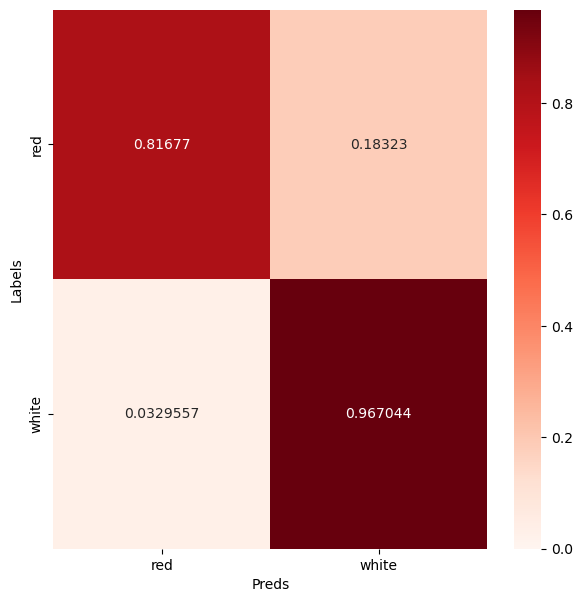

In [11]:
cnfs = confusion_matrix(y_test, y_pred, normalize="true")
plt.figure(figsize=(7,7))
sns.heatmap(cnfs,
            annot=True,
            cmap="Reds",
            vmin=0,
            fmt='g',
           )
plt.xlabel("Preds")
plt.xticks(ticks=[0.5,1.5], labels=svclassifier.classes_)
plt.yticks(ticks=[0.5,1.5], labels=svclassifier.classes_)
plt.ylabel("Labels")

SVMs are quite strong when dealing with noise, high dimensional spaces, and low complexity problems. They tend to arrive at better global solutions, and we can see our results generalized quite beautifully! Still, they tend to be harmed by data imbalance, and this has caused a difference of 15% between red and white wine classification.

Handling confusion matrices can be a bit cumbersome, so let's discuss three (yes, three!) new metrics we can use to describe our results:

## Metrics: Precison, Recall, and F1 Scores

Precision and Recall (also known as Sensitivity) are two important metrics that categorize our model in different ways:
- Precision will be high if your model says that something is true **ONLY WHEN IT IS TRUE**. Models with high precision are great for problems where saying that something is true can be quite costly. Things like recommendation systems or assigning fault to people benefit from high precision, as it means our model will be very certain of something when it says it. 
- Recall will be high if your model says that something is true **EVEN AT THE COST OF IT BEING FALSE**. Models with high recall are great for problems where you really, really do not want to say that something isn't when *it could be*. Imagine a medical system to detect cancer: It is much better to have high recall (ensuring you will not give a false negative) even if your precision is low (even if you waste time and resources).


In other words, Precision **rewards true positive**, and Recall **punishes false negatives**.

We can combine both of these metrics with the F1 Score, which is the average of the two metrics (more or less).

| Metric           | Formula                                     | Measures                                                                                                                                                                                    |
|------------------|---------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Accuracy         | TP+TN / TP+TN+FP+FN                         | The amount of labels that were correctly predicted. Works excellently with balanced datasets                                                                                                |
| Confusion Matrix | N/A                                         | Everything! It requires interpretation and can be difficult to compare.                                                                                                                     |
| Precision        | TP / TP + FP                                | The percentage of the positive predictions that the model got correctly. High precision means that the model is unlikely to say something is of this category when it isn't.                |
| Recall           | TP / TP + FN                                | The percentage of the positive predictions that the model did not confuse with negatives. High recall means that the model is unlikely to say something is NOT of this category when it is. |
| F1 Score         | 2 * Precision * Recall / Precision + Recall | An "average" of the precision and recall, serves as a combined measurement.                                                                                                                 |

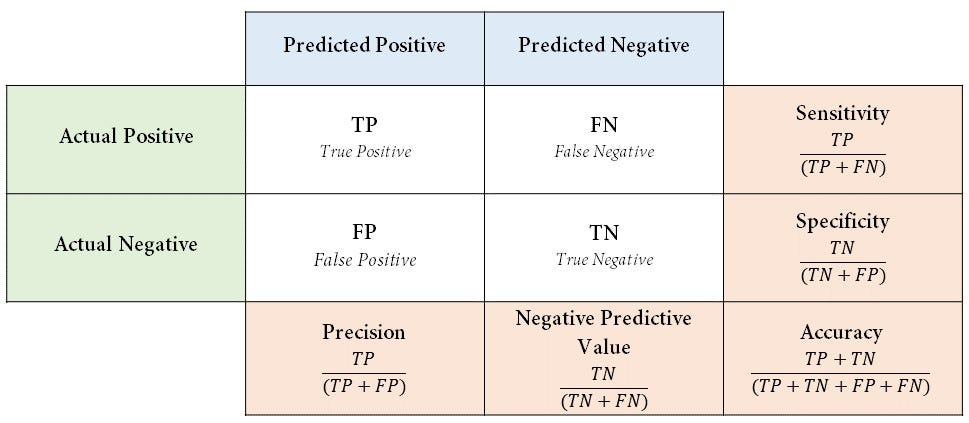

In [12]:
def get_scores(y_true, y_pred, positive):
    f1 = f1_score(y_true, y_pred, average='binary', pos_label=positive)
    recall = recall_score(y_true, y_pred, average='binary', pos_label=positive)
    precision = precision_score(y_true, y_pred, average='binary', pos_label=positive)
    print("The scores for "+str(positive)+" are: ")
    print("------------------")
    print("F1 SCORE : ",f1)
    print("RECALL   : ",recall)
    print("PRECISION: ",precision)
    return f1, recall, precision

get_scores(y_test, y_pred, positive='red')

The scores for red are: 
------------------
F1 SCORE :  0.8525121555915721
RECALL   :  0.8167701863354038
PRECISION:  0.8915254237288136


(0.8525121555915721, 0.8167701863354038, 0.8915254237288136)

In [13]:
get_scores(y_test, y_pred, positive="white")

The scores for white are: 
------------------
F1 SCORE :  0.9537836465210767
RECALL   :  0.9670442842430484
PRECISION:  0.9408817635270541


(0.9537836465210767, 0.9670442842430484, 0.9408817635270541)

So, as we can see, this model has the follwing attributes:
- It has **high precision**, and **high recall** for *white* wine. It means it is very likely to correctly predict that a wine is white, and is it unlikely to say that a wine is red when it is white.
- It has **high precision**, but **lower recall** for *red* wine. It means that is is likely to be correct if it ever says that a wine is red, but it may say that a wine is white when it is red.

One final idea: Each of these scores is *per class*! This means they do not care *how many entries each class has*, but rather, *how each class individually performs*. That means it is possible to get the average of each class to have a metric that can tell you how good a model does *regardless of balancing*! We call these average precision, average recall, and average F1 scores. You can access them by simply adding the average='macro' or average='weighted' in the score function.

In [14]:
f1_score(y_test, y_pred, average="macro")

0.9031479010563244

This means our model's performance is more about a 90% rather than the 93% accuracy reported. It's still pretty good! Can we do anything to make it even better? Maybe, but there will likely be a trade-off between recall and precision.

## Encoding: Integer Encoding and One-Hot Encoding
Something that is likely to cause problems in multiple class classification is how we handle our target column. Not doing anything is a possible choice, but we can get a little bit more performance from our model by considering how we describe this data. 

Two ideas are natural to use:
- Assign each category to a different integer
- Assign each category to a different binary column

We discussed these more in-depth during class, and long story short, One-Hot Encoding should be your default option (memory permitting). Some models are more or less sensitive to which encoder you use: Neural Networks in particular will not like integer encoding. 

To visualize what these encoders do, we will use our old friend, seattle-weather.csv. This dataset has multiple categories, so we can see what each encoder does:

In [15]:
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, OneHotEncoder
weather = pd.read_csv("seattle-weather.csv")["weather"]
weather

FileNotFoundError: [Errno 2] No such file or directory: 'seattle-weather.csv'

In [ ]:
le = LabelEncoder()
le.fit(weather)
y_transformed = le.transform(weather)
pd.DataFrame(y_transformed)

,0
0,0
1,2
2,2
3,2
4,2
...,...
1456,2
1457,2
1458,1
1459,4


With LabelEncoder(), we assign each category to an integer in a single column, from 0 to 4 for 5 classes.

In [ ]:
le.inverse_transform(y_transformed)

array(['drizzle', 'rain', 'rain', ..., 'fog', 'sun', 'sun'], dtype=object)

In [ ]:
ohe = LabelBinarizer()
ohe.fit(weather)
y_ohe = ohe.transform(weather)
pd.DataFrame(y_ohe)

,0,1,2,3,4
0,1,0,0,0,0
1,0,0,1,0,0
2,0,0,1,0,0
3,0,0,1,0,0
4,0,0,1,0,0
...,...,...,...,...,...
1456,0,0,1,0,0
1457,0,0,1,0,0
1458,0,1,0,0,0
1459,0,0,0,0,1


With One-Hot encoding, we assign each label to a separate column, a total of 5 columns for 5 classes. Note that for the case of binary classification, this is exactly the same: One binary column, or two integers in a single column (which is... well, a binary column).

Let's transform our y data to our integer representation! Note that SciKit Learn does this internally for binary cases, so this will not have a significant effect on our performance for the wine dataset.

In [ ]:
le = LabelEncoder()
le.fit(y)
y_transformed = le.transform(y)
pd.DataFrame(y_transformed)

,0
0,1
1,1
2,1
3,1
4,1
...,...
6458,0
6459,0
6460,0
6461,0


In [ ]:
le.inverse_transform(y_transformed)

array(['white', 'white', 'white', ..., 'red', 'red', 'red'], dtype=object)

## Imbalanced Data: Resampling
So far, we have hand-waved away the problem of balanced data by using weighting to increase or decrease the importance of each class. This, however, does not solve the problem we actually have:

**Our data favors one class over other.**

This simple fact means that our model has two options: It *learns less*, because it cannot make use of data that favors the majority class, or it *learns in a skewed manner*, because it assumes the real world favors the majority class.

Most often this is an unwanted behavior. There is no magic bullet to fix this, but we can take advantage of a powerful technique: Resampling.

First, we will need a new library: Imbalanced Learn

In [ ]:
!pip install imbalanced-learn

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, train_size=0.8, random_state=42, shuffle=True)
# Our data has changed since we made the encoding, so we resplit it.

Resampling is simple: Instead of using the samples we already have, we will... well, sample again! We take data from our dataset as it if was our total population, with the goal of achieving a more balanced class outlook.

We have to possible options:
- We **undersample**, by taking less examples of the majority class.
- We **oversample**, by taking more examples of the minority class.

Something to consider: Resampling will *change the distribution of your data*. Unless you have a good reason for doing so, **do NOT** apply resampling to your test set.

### Undersampling
This technique is simple in theory: We just take less of the majority class! We can use something like random sampling.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_under, y_under = rus.fit_resample(X_train, y_train)
X_under

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
5318,9.5,0.56,0.33,2.4,0.089,35.0,67.0,0.99720,3.28,0.73,11.8,7
6235,6.0,0.50,0.00,1.4,0.057,15.0,26.0,0.99448,3.36,0.45,9.5,5
4948,8.8,0.66,0.26,1.7,0.074,4.0,23.0,0.99710,3.15,0.74,9.2,5
5945,7.1,0.43,0.17,1.8,0.082,27.0,51.0,0.99634,3.49,0.64,10.4,5
4907,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.99780,3.35,0.80,10.5,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1970,8.3,0.49,0.43,2.5,0.036,32.0,116.0,0.99440,3.23,0.47,10.7,6
1997,8.4,0.20,0.38,11.8,0.055,51.0,170.0,1.00040,3.34,0.82,8.9,6
957,6.6,0.23,0.32,0.9,0.041,25.0,79.0,0.99260,3.39,0.54,10.2,7
2379,6.4,0.27,0.19,2.0,0.084,21.0,191.0,0.99516,3.49,0.63,9.6,4


Text(0.5, 1.0, 'Balance of Red vs White wine')

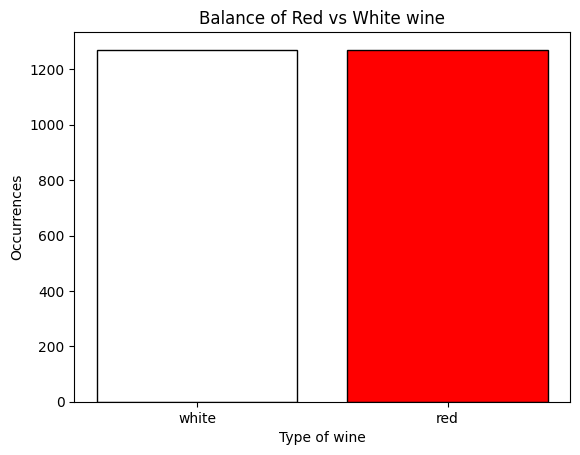

In [ ]:
plt.bar(["white","red"], pd.DataFrame(y_under).value_counts(),
        color = ["white","red"],
        edgecolor = ["black",[0,0,0]]
       )
plt.xlabel("Type of wine")
plt.ylabel("Occurrences")
plt.title("Balance of Red vs White wine")

Notice how we have now a balanced dataset... but we also have *less* data! This can be okay if we have enough data for training, but sometimes (particularly for grossly imbalanced datasets) this can be unwanted.

### Oversampling
This one is not so intuitive: How can we sample *more* of the minority class if we... well, we do not HAVE more of the minority class? The answer is also not so simple, because we need to **make** more of our data. There are multiple ways of doing so, for example, by duplicatiing entries randomly. The best methods usually make use of another model, such as K-Means or K-Nearest Neighbors to create *synthetic* data. This is not as good as real data, but it can provide extra information for your model to train on.

In this example, we use ADASYN, which makes use of K-NN to interpolate new data points for your minority class.

In [ ]:
from imblearn.over_sampling import ADASYN
over_ada = ADASYN(random_state=42)
X_over, y_over = over_ada.fit_resample(X_train, y_train)
X_over

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,6.100000,0.430000,0.350000,9.100000,0.059000,83.000000,249.000000,0.997100,3.370000,0.500000,8.500000,5
1,8.500000,0.170000,0.740000,3.600000,0.050000,29.000000,128.000000,0.992800,3.280000,0.400000,12.400000,6
2,5.200000,0.220000,0.460000,6.200000,0.066000,41.000000,187.000000,0.993620,3.190000,0.420000,9.733333,5
3,6.300000,0.400000,0.240000,5.100000,0.036000,43.000000,131.000000,0.991860,3.240000,0.440000,11.300000,6
4,6.700000,0.340000,0.260000,1.900000,0.038000,58.000000,138.000000,0.989300,3.000000,0.470000,12.200000,7
...,...,...,...,...,...,...,...,...,...,...,...,...
7821,10.173064,0.885351,0.374170,3.064206,0.080598,25.671588,87.671588,0.998843,3.132546,0.586421,9.968635,5
7822,9.341239,0.623006,0.265393,3.384139,0.089556,25.031722,87.031722,0.999707,3.234924,0.618414,9.712689,5
7823,8.390557,0.545804,0.297448,2.597550,0.081441,26.069933,85.930067,0.998311,3.330944,0.598601,9.325523,5
7824,9.235914,0.605476,0.262639,3.343453,0.089397,25.075395,86.924605,0.999649,3.246409,0.618492,9.673612,5


Text(0.5, 1.0, 'Balance of Red vs White wine')

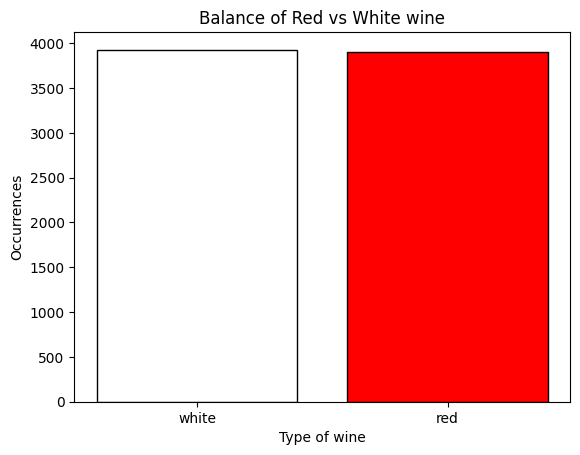

In [ ]:
plt.bar(["white","red"], pd.DataFrame(y_over).value_counts(),
        color = ["white","red"],
        edgecolor = ["black",[0,0,0]]
       )
plt.xlabel("Type of wine")
plt.ylabel("Occurrences")
plt.title("Balance of Red vs White wine")

Now we have *more*, and *balanced* data!

## Putting it all together
Let's make some tests using some of our resampling techniques and our encoders!

### With undersampling

In [ ]:
svclassifier = SVC(
    C = 1.0,
    kernel = 'poly',
    degree = 2,
    class_weight = None,
    max_iter = 10000,
    random_state = 42,
)

svclassifier.fit(X_under,y_under)

y_pred = svclassifier.predict(X_test)
y_pred = le.inverse_transform(y_pred)
y_test = le.inverse_transform(y_test)

get_scores(y_test, y_pred, positive="red")

The scores for red are: 
------------------
F1 SCORE :  0.8153409090909091
RECALL   :  0.8913043478260869
PRECISION:  0.7513089005235603


(0.8153409090909091, 0.8913043478260869, 0.7513089005235603)

In [ ]:
get_scores(y_test, y_pred, positive="white")

The scores for white are: 
------------------
F1 SCORE :  0.9309245483528161
RECALL   :  0.90216271884655
PRECISION:  0.9615806805708014


(0.9309245483528161, 0.90216271884655, 0.9615806805708014)

In [ ]:
f1_score(y_test, y_pred, average="macro")

0.8731327287218626

Text(0.5, 1.0, 'Undersampled performance')

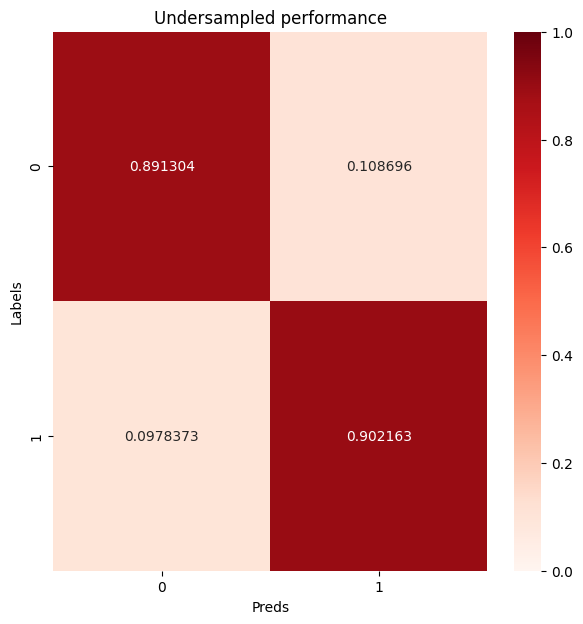

In [ ]:
cnfs = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(7,7))
sns.heatmap(cnfs,
            annot=True,
            cmap="Reds",
            vmax=1,
            vmin=0,
            fmt='g',
           )
plt.xlabel("Preds")
plt.xticks(ticks=[0.5,1.5], labels=svclassifier.classes_)
plt.yticks(ticks=[0.5,1.5], labels=svclassifier.classes_)
plt.ylabel("Labels")
plt.title("Undersampled performance")

### With oversampling

In [ ]:
svclassifier = SVC(
    C = 1.0,
    kernel = 'poly',
    degree = 2,
    class_weight = None,
    max_iter = 10000,
    random_state = 42,
)

svclassifier.fit(X_over,y_over)

y_pred = svclassifier.predict(X_test)
y_pred = le.inverse_transform(y_pred)

get_scores(y_test, y_pred, positive="red")

The scores for red are: 
------------------
F1 SCORE :  0.7511961722488039
RECALL   :  0.9751552795031055
PRECISION:  0.6108949416342413


(0.7511961722488039, 0.9751552795031055, 0.6108949416342413)

In [ ]:

get_scores(y_test, y_pred, positive="white")

The scores for white are: 
------------------
F1 SCORE :  0.8811428571428572
RECALL   :  0.7940267765190525
PRECISION:  0.9897304236200257


(0.8811428571428572, 0.7940267765190525, 0.9897304236200257)

In [ ]:
f1_score(y_test, y_pred, average="macro")

0.8161695146958305

Text(0.5, 1.0, 'Oversampled performance')

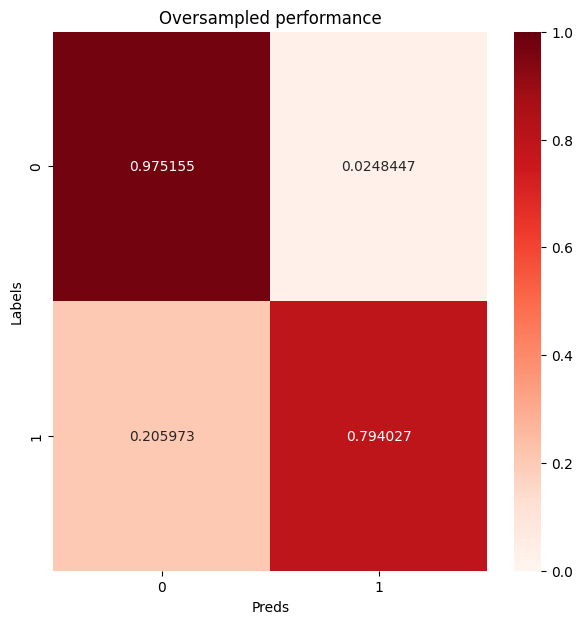

In [ ]:
cnfs = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(7,7))
sns.heatmap(cnfs,
            annot=True,
            cmap="Reds",
            vmax=1,
            vmin=0,
            fmt='g',
           )
plt.xlabel("Preds")
plt.xticks(ticks=[0.5,1.5], labels=svclassifier.classes_)
plt.yticks(ticks=[0.5,1.5], labels=svclassifier.classes_)
plt.ylabel("Labels")
plt.title("Oversampled performance")

## Conclusion
So, what can we conclude from these tests? 

Observe that there is no magic bullet: Our model won some performance in some ways, but also lost some in other ways. Particularly, notice that increasing our red wine recall impacted our precision. 

The best model overall was the first one we made, but consider: Could the results be better if we use a less aggressive form of balancing (say we only make a 60-40 imbalance instead of forcing a 50-50)?

What about using different hyperparameters? We only tested with a polynomial kernel: Maybe the actual data is better suited to another kernel.

And what about decision trees? Could that one have performed better?

Many of these questions can only be answered through the use of *validation*, which we have yet to learn! Next time we will discuss how to use it to adjust all of these hyperparameters and more.

In [ ]:
recall_score(y_test, y_pred, average='macro') # one vs rest

0.884591028011079

In [ ]:
np.random.seed(89)
np.random.rand()


0.499694320468834